<a href="https://colab.research.google.com/github/KimYongHwi/machine-learning-study/blob/main/natural_language_processing/2_%ED%82%A4%EC%9B%8C%EB%93%9C_%EB%B6%84%EC%84%9D(Keyword_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 키워드 분석 (Keyword Analysis)
- 핵심어(keyword)란 텍스트 자료의 중요한 내용을 압축적으로 제시하는 단어 또는 문구
- 핵심어 분석이란 불용어 제거와 어간추출 및 형태소 분석등의 자연어 처리를 시행한 후 텍스트에서 많이 등장하는 형태소의 등장 빈도를 분석함으로써 핵심어를 추출
- 특정 텍스트 자료에 많이 나타나는 형태소가 그 텍스트 주제를 표출할 가능성이 높다는 가정에 기초
- 키워드 분석은 텍스트의 주제 추정, 텍스트 유사도, 검색 엔진의 검색 결과 우선순위 측정 등 다양하게 사용될 수 있음

#### 한글 폰트 설정
- 실행 후 런타임 재시작 필요

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

%config InlineBackend.figure_format='retina'
!apt -qq -y install fonts-nanum

# import matplotlib.font_manager as fm
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.


#### 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치
- https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh

In [ ]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

### 네이버 영화 리뷰 데이터
- 데이터 다운로드: https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt

In [10]:
import urllib.request

raw = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt').readlines()
print(raw[:5])

[b'id\tdocument\tlabel\n', b'8112052\t\xec\x96\xb4\xeb\xa6\xb4\xeb\x95\x8c\xeb\xb3\xb4\xea\xb3\xa0 \xec\xa7\x80\xea\xb8\x88\xeb\x8b\xa4\xec\x8b\x9c\xeb\xb4\x90\xeb\x8f\x84 \xec\x9e\xac\xeb\xb0\x8c\xec\x96\xb4\xec\x9a\x94\xe3\x85\x8b\xe3\x85\x8b\t1\n', b'8132799\t\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb8\xec\x9d\x84 \xeb\xb0\xb0\xec\x9a\xb0\xeb\x8a\x94 \xed\x95\x99\xec\x83\x9d\xec\x9c\xbc\xeb\xa1\x9c, \xec\x99\xb8\xea\xb5\xad\xeb\x94\x94\xec\x9e\x90\xec\x9d\xb4\xeb\x84\x88\xec\x99\x80 \xea\xb7\xb8\xeb\x93\xa4\xec\x9d\xb4 \xec\x9d\xbc\xea\xb5\xb0 \xec\xa0\x84\xed\x86\xb5\xec\x9d\x84 \xed\x86\xb5\xed\x95\xb4 \xeb\xb0\x9c\xec\xa0\x84\xed\x95\xb4\xea\xb0\x80\xeb\x8a\x94 \xeb\xac\xb8\xed\x99\x94\xec\x82\xb0\xec\x97\x85\xec\x9d\xb4 \xeb\xb6\x80\xeb\x9f\xac\xec\x9b\xa0\xeb\x8a\x94\xeb\x8d\xb0. \xec\x82\xac\xec\x8b\xa4 \xec\x9a\xb0\xeb\xa6\xac\xeb\x82\x98\xeb\x9d\xbc\xec\x97\x90\xec\x84\x9c\xeb\x8f\x84 \xea\xb7\xb8 \xec\x96\xb4\xeb\xa0\xa4\xec\x9a\xb4\xec\x8b\x9c\xec\xa0\x88\xec\x97\x90 \xeb\x81\x9d

- 데이터를 확인해보면 모두 바이트로 이루어져 있으며, 리뷰 외데 다른 데이터도 존재
- 데이터를 문자열로 변환하고 리뷰만 추출

In [12]:
raw = [x.decode() for x in raw[1:]]
reviews = []
for i in raw:
    reviews.append(i.split('\t')[1]) # 1번째 인덱스가 리뷰

### 형태소 분석을 이용한 명사 추출
- 형태소 분석기 MeCab으로 명사만 추출

In [20]:
from konlpy.tag import Mecab
tagger = Mecab()

nouns = []
for review in reviews:
    for noun in tagger.nouns(review):
        nouns.append(noun)

### 불용어 사전 만들기
- 형태소 분석을 통해 조사, 접속사 등 제거 가능
- 하지만 한국어는 명사에서도 불필요한 단어들이 포함
- 사용자가 직접 불용어 사전을 유지하면서 불필요한 단어 제거 필요
- 불용어 예: `전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것`
- 빈도가 너무 커서 분석에 방해되는 단어도 제거 필요(예: `영화`)

In [ ]:
stop_words = "영화 전 난 일 걸 뭐 줄 만 건 분 개 끝 잼 이거 번 중 듯 때 게 내 말 나 수 거 점 것".split(' ')

### 불용어를 제외하여 형태소 분석 수행
- 한글 텍스트에 대해서 형태소 분석 수행
- 분석으로 추출하는 명사중에서 불용어에 포함되지 않는 텍스트만 추출하여 저장

In [22]:
nouns = []
for review in reviews:
    for noun in tagger.nouns(review):
        if noun not in stop_words:
            nouns.append(noun)

nouns[:10]

['디자인', '학생', '외국', '디자이너', '그', '전통', '발전', '문화', '산업', '우리']

### 단어 빈도수 측정
- 단어 빈도수 측정에는 `collections`라이브러리의 `Counter`메소드를 이용
- `collections`라이브러리는 내장 라이브러리 별도 설치가 필요없음
- `counter`를 이용하면 각 단어와 각 단어의 빈도 수를 딕셔너리로 편리하게 생성 가능

In [ ]:
from collections import Counter

nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(50))

### 단어 빈도 시각화

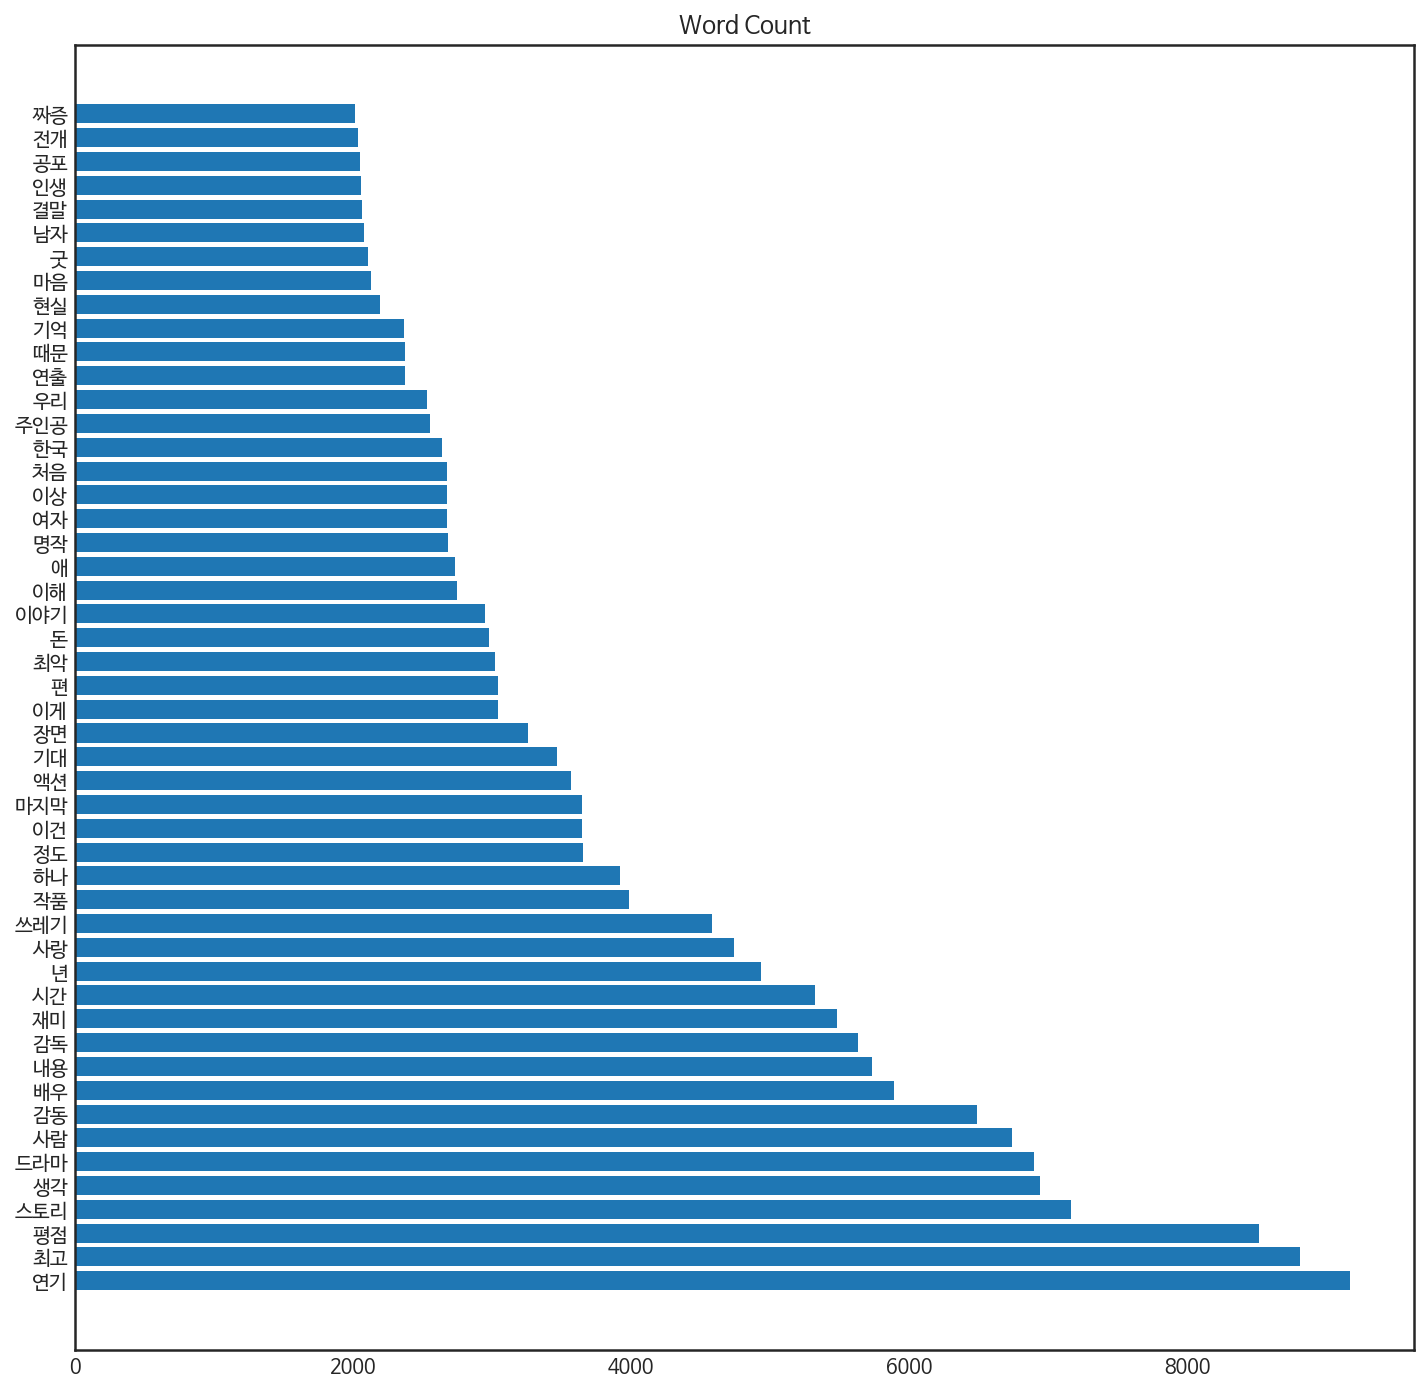

In [28]:
import numpy as np

y_pos = np.arange(len(top_nouns))

figure = plt.figure(figsize=(12, 12))
plt.barh(y_pos, top_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_nouns.keys())
plt.show()

### 워드클라우드
- 텍스트에 담겨 있는 여러 형태소들의 등장 빈도를 가장 직관적으로 시각화하는 방법
- 텍스트에 등장하는 단어를 그 등장 빈도에 따라 서로 크기가 다르게 구름 형태로 표현함으로써, 단어의 빈도 수를 한번에 알 수 있음
- 최근에 많은 서비스들이 어떤 핵심어가 많이 등장했는가를 워드클라우드 형식으로 시각화
- 빈소수만을 시각적으료 표현한것이기 때문에, 단어들 사이의 연관성이나 의미 구조 등을 분석하는 데는 한계가 있음


In [29]:
!pip install wordcloud

- WordCloud를 이용해 객체를 생성해주고, `generate_from_frequencies()` 메소드로 빈소 수에 따라 워드클라우드 생성

In [30]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white', font_path='./font/NanumGothic.ttf')
wc.generate_from_frequencies(top_nouns)

- 워드클라우드를 시각화할 때는 이미지 시각화 메소드인 `imshow()`를 사용

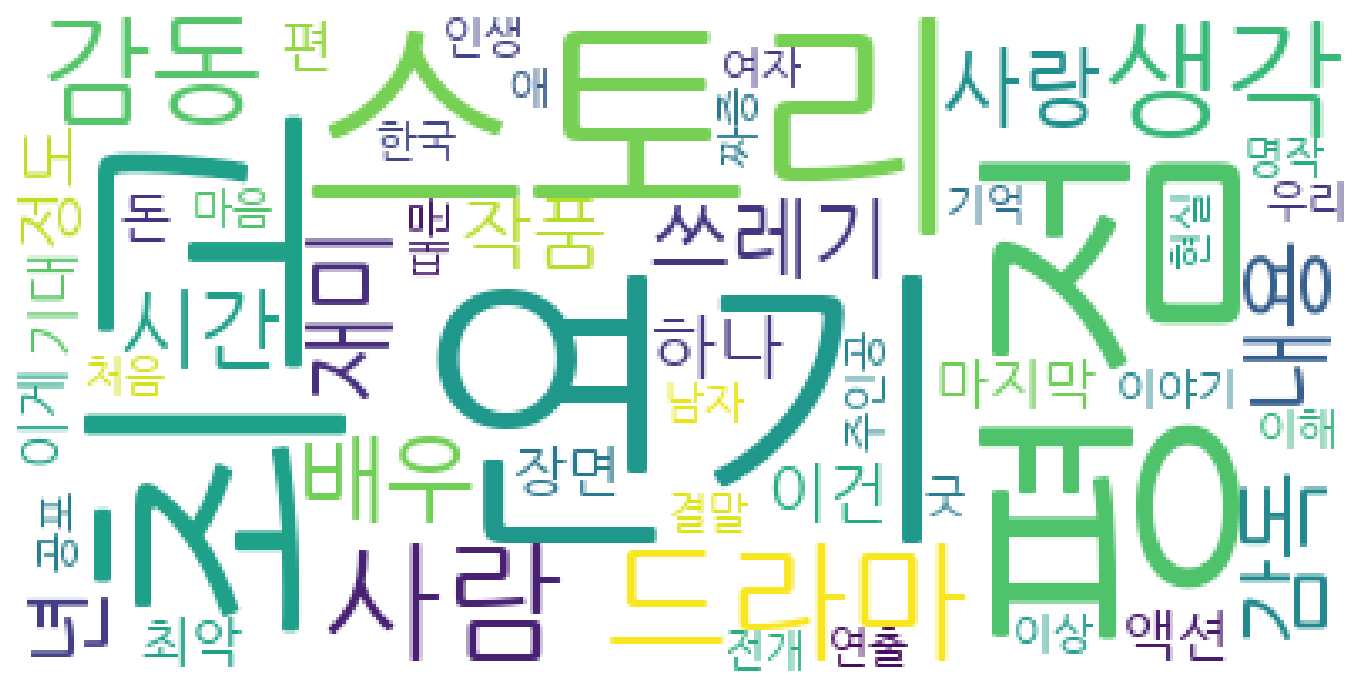

In [33]:
figure = plt.figure(figsize=(12,12))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

### squarify 트리맵 시각화
- `squarify`는 트리맵 생성을 지원해주는 파이썬 라이브러리
- `squarify` 라이브러리를 이용해 키워드와 키워드 빈도수를 트리맵으로 나타냄

In [ ]:
!pip install squarify

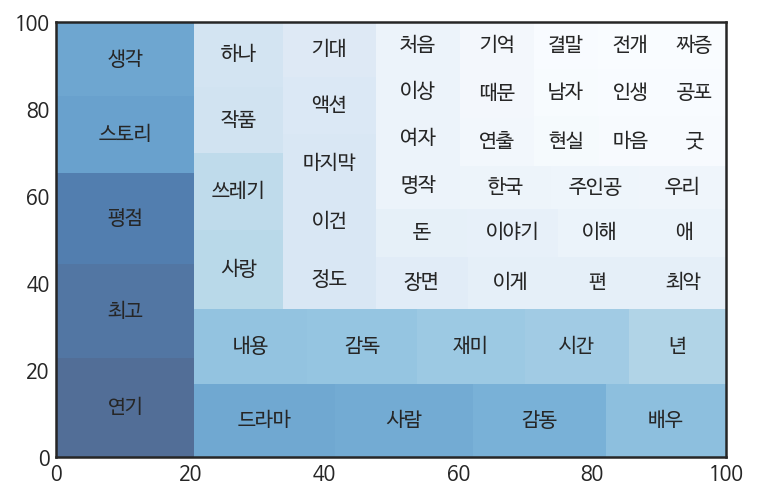

In [38]:
import squarify

norm = mpl.colors.Normalize(vmin=min(top_nouns.values()), vmax=max(top_nouns.values()))
colors = [mpl.cm.Blues(norm(value)) for value in top_nouns.values()] # 빈도수 별 색을 다르게 함

squarify.plot(label=top_nouns.keys(),
              sizes=top_nouns.values(),
              color=colors,
              alpha=.7)